The file is modified from classify_text_with_bert, with the majority of data-loading being unmodified.
The majority of explainer text is removed from the original, and the model used has been modified.

-> Kept from original file
Copyright 2020 The TensorFlow Hub Authors.
Licensed under the Apache License, Version 2.0

In [1]:
# Installs required dependencies
#!pip install -q -U tensorflow-text

# AdamW optimizer
#!pip install -q tf-models-official

In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [3]:
# Load Data form downloaded folder.
# The data should be in a folder the same level as the .ipynb file.
# Data should be taken from Google Repo.

parent = os.getcwd()
dataset_dir = os.path.join(parent, 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')

In [4]:
# Initial Parameters, Unmodified

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


### BERT models form TensorFlow
Here is where the tutorial and the code that I wrote begins to diverge.
We start with a different choice of model to correspond to the NLP task at hand.

In [5]:
bert_model_name = 'electra_small'

handle_encoder = 'https://tfhub.dev/google/electra_small/2'
handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {handle_encoder}')
print(f'Preprocess model auto-selected: {handle_preprocess}')

BERT model selected           : https://tfhub.dev/google/electra_small/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


### Pre-Processing and BERT
Be sure to clear the tf_modules TEMP folder, and then delete it to re-download the module if there are errors.
The model of choice is the Electra Model, which is based on BERT, with minor modifications.
Pre-processing of text is given, and is usually truncated to the first 128 items.

In [6]:
bert_preprocess_model = hub.KerasLayer(handle_preprocess, name="preprocessing")
bert_model = hub.KerasLayer(handle_encoder, trainable=True, name="electra")

In [7]:
# Verify that the model was loaded correctly

text_test = ['The preprocess maps text to a set of integers, similar to bag of words.']
text_preprocessed = bert_preprocess_model(text_test)
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {handle_encoder}')

print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :10]}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :10]}')

Loaded BERT: https://tfhub.dev/google/electra_small/2
Word Ids   : [  101  1996 17463  3217  9623  2015  7341  3793  2000  1037]
Pooled Outputs Values:[ 0.38453108  0.18330958 -0.5463094   0.13135742 -0.6035003  -0.07489084
  0.8030998   0.73567134  0.712655   -0.23594138]


In [27]:
# Define the model. Changes to the architecture of the model should take place here.

def build_classifier_model():
    # Get raw text, Preprocess it, then pass it through the existing model. Functionally identical to old code.
    raw_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    inputs = bert_preprocess_model(raw_input)
    encoder = bert_model
    outputs = encoder(inputs)
    net = outputs['pooled_output']

    # Refining Layer(s)
    net = tf.keras.layers.Dense(12, activation="sigmoid", name='hidden')(net)
    net = tf.keras.layers.Dropout(0.1, name='dropout')(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(raw_input, net)

In [28]:
# Check that the model runs with the output of the preprocessing model.

classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5626942]], shape=(1, 1), dtype=float32)


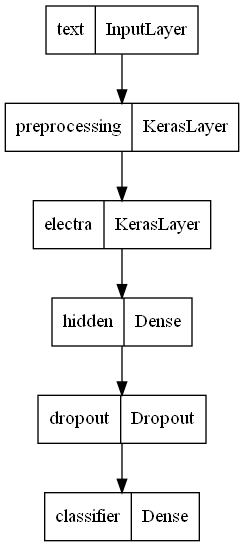

In [29]:
# While the prior function could have been replaced with a keras.Sequential, but there is little reason to change it.
tf.keras.utils.plot_model(classifier_model)

In [30]:
# Define the loss function
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define the metric of accuracy
metrics = tf.metrics.BinaryAccuracy()

In [31]:
# Define the manner of training
epochs = 4 # loss increases due to over-fit after ~3 epochs
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [32]:
# Compile the model
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [33]:
# Train the model
print(f'Training model with {handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/google/electra_small/2
Epoch 1/4
625/625 [==============================] - 234s 364ms/step - loss: 0.3033 - binary_accuracy: 0.8953 - val_loss: 0.3684 - val_binary_accuracy: 0.8606
Epoch 2/4
625/625 [==============================] - 225s 360ms/step - loss: 0.2024 - binary_accuracy: 0.9423 - val_loss: 0.4271 - val_binary_accuracy: 0.8600
Epoch 3/4
625/625 [==============================] - 225s 360ms/step - loss: 0.1799 - binary_accuracy: 0.9537 - val_loss: 0.4328 - val_binary_accuracy: 0.8614
Epoch 4/4
625/625 [==============================] - 226s 362ms/step - loss: 0.1587 - binary_accuracy: 0.9617 - val_loss: 0.4238 - val_binary_accuracy: 0.8656


In [34]:
# Evaluate the Model

loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 93s 118ms/step - loss: 0.4098 - binary_accuracy: 0.8684
Loss: 0.4098067283630371
Accuracy: 0.868399977684021


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


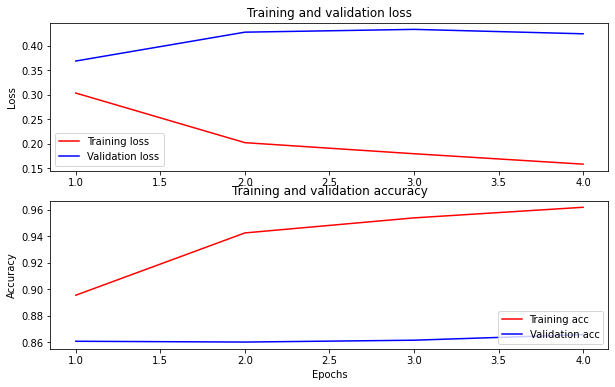

In [35]:
# The following code is unchanged from the original file, baring minor edits.

history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [36]:
# Export the model for later use

saved_model_path = './imdb_models/electra_modified'
classifier_model.save(saved_model_path, include_optimizer=False)